# Modeling foam flow in porous media
I'm solving 1D and 2D foam flow in porous media numerically and analytically.

In [11]:
# using PyPlot
using JFVM, JFVMvis
using Plots

## Physical properties and rel-perms

In [12]:
muw = 0.001 # water viscosity
mug = 2e-5 # gas viscosity
perm_ave = 1e-12 # permeability
poros_ave = 0.2 # porosity
fmmob = 25000
fmdry = 0.29
epdry = 10000
swc = 0.1
sgr = 0.05
krg0 = 0.94
ng = 1.3
krw0 = 0.2
nw = 4.2
# sws(sw)=((sw.>swc).*(sw.<(1-sgr)).*(sw-swc)/(1-sgr-swc))+(sw.>(1-sgr)).*ones(size(sw))
# kr(sw)=(krg0*(1-sws(sw)).^ng)
# fm(sw)=(1+fmmob*(0.5+atan(epdry.*(sw-fmdry))/π))
# krg(sw)=(kr(sw)./fm(sw))
# krw(sw)=(krw0*sws(sw).^nw)
# dkrwdsw(sw)=(nw*krw0*(1/(1-sgr-swc))*sws(sw).^(nw-1))
# dkrdsw(sw)=((krg0*ng*(1-sws(sw)).^(ng-1))/(-swc-sgr+1))
# dfmdsw(sw)=(((epdry*fmmob)./(π*(epdry^2*(sw-fmdry).^2+1))))
# dkrgdsw(sw)=((dkrdsw(sw).*fm(sw)-dfmdsw(sw).*kr(sw))./fm(sw).^2)
# fw(sw)=((krw(sw)/muw)./(krw(sw)/muw+krg(sw)/mug))
# dfw(sw)=((dkrwdsw(sw)/muw.*(krw(sw)/muw+krg(sw)/mug)-
#     (dkrwdsw(sw)/muw+dkrgdsw(sw)/mug).*krw(sw)/muw)./
#     (krg(sw)/mug+krw(sw)/muw).^2)

sws(sw)=((sw>swc)*(sw<(1-sgr))*(sw-swc)/(1-sgr-swc))+(sw>(1-sgr))
kr(sw)=(krg0*(1-sws(sw))^ng)
fm(sw)=(1+fmmob*(0.5+atan(epdry*(sw-fmdry))/π))
krg(sw)=(kr(sw)/fm(sw))
krw(sw)=(krw0*sws(sw)^nw)
dkrwdsw(sw)=(nw*krw0*(1/(1-sgr-swc))*sws(sw)^(nw-1))
dkrdsw(sw)=((krg0*ng*(1-sws(sw))^(ng-1))/(-swc-sgr+1))
dfmdsw(sw)=(((epdry*fmmob)/(π*(epdry^2*(sw-fmdry)^2+1))))
dkrgdsw(sw)=((dkrdsw(sw)*fm(sw)-dfmdsw(sw)*kr(sw))/fm(sw)^2)
fw(sw)=((krw(sw)/muw)/(krw(sw)/muw+krg(sw)/mug))
dfw(sw)=((dkrwdsw(sw)/muw*(krw(sw)/muw+krg(sw)/mug)-
    (dkrwdsw(sw)/muw+dkrgdsw(sw)/mug)*krw(sw)/muw)/
    (krg(sw)/mug+krw(sw)/muw)^2)

dfw (generic function with 1 method)

In [13]:
# Visualize relative permeabilities
sw_r = range(0.0, 1.0, length=100)
plot(sw_r, mug.*fm.(sw_r), 
    xlabel= "Liquid saturation", 
    ylabel= "Foam viscosity [Pa.s]", 
    label="",
    xtickfontsize=10,
    ytickfontsize=10,
    dpi=300)
savefig("foam_apparent_viscosity.png")

## Domain & grid

In [14]:
# Geometry
m = 80 # number of cells in x direction
n = 50 # number of cells in y direction
W = 10 # width
H = 1 # height
x=[range(0, 0.2, length=100); range(0.21, 1.0, length=10)]
meshvar = createMesh1D(x)

MeshStructure(1, [109], JFVM.CellSize{Float64}([0.00202020202020202, 0.00202020202020202, 0.00202020202020202, 0.00202020202020202, 0.00202020202020202, 0.002020202020202021, 0.0020202020202020193, 0.002020202020202021, 0.0020202020202020193, 0.0020202020202020193  …  0.08777777777777776, 0.08777777777777779, 0.08777777777777779, 0.08777777777777779, 0.08777777777777773, 0.08777777777777784, 0.08777777777777773, 0.08777777777777784, 0.08777777777777773, 0.08777777777777773], [0.0], [0.0]), JFVM.CellLocation{Float64}([0.00101010101010101, 0.0030303030303030303, 0.00505050505050505, 0.007070707070707071, 0.00909090909090909, 0.011111111111111112, 0.013131313131313133, 0.015151515151515152, 0.01717171717171717, 0.01919191919191919  …  0.20500000000000002, 0.2538888888888889, 0.3416666666666667, 0.4294444444444444, 0.5172222222222222, 0.605, 0.6927777777777777, 0.7805555555555556, 0.8683333333333334, 0.9561111111111111], [0.0], [0.0]), JFVM.FaceLocation{Float64}([0.0, 0.00202020202020202, 

## Assign the properties to the cells

In [15]:
poros = createCellVariable(meshvar, poros_ave)
perm = createCellVariable(meshvar, perm_ave)
mu_gas = createCellVariable(meshvar, mug) # gas viscosity
mu_water = createCellVariable(meshvar, muw) # water viscosity
Lg_ave = harmonicMean(perm/mu_gas)
Lw_ave = harmonicMean(perm/mu_water)
s = createCellVariable(meshvar, 0) # gas source term

CellValue(MeshStructure(1, [109], JFVM.CellSize{Float64}([0.00202020202020202, 0.00202020202020202, 0.00202020202020202, 0.00202020202020202, 0.00202020202020202, 0.002020202020202021, 0.0020202020202020193, 0.002020202020202021, 0.0020202020202020193, 0.0020202020202020193  …  0.08777777777777776, 0.08777777777777779, 0.08777777777777779, 0.08777777777777779, 0.08777777777777773, 0.08777777777777784, 0.08777777777777773, 0.08777777777777784, 0.08777777777777773, 0.08777777777777773], [0.0], [0.0]), JFVM.CellLocation{Float64}([0.00101010101010101, 0.0030303030303030303, 0.00505050505050505, 0.007070707070707071, 0.00909090909090909, 0.011111111111111112, 0.013131313131313133, 0.015151515151515152, 0.01717171717171717, 0.01919191919191919  …  0.20500000000000002, 0.2538888888888889, 0.3416666666666667, 0.4294444444444444, 0.5172222222222222, 0.605, 0.6927777777777777, 0.7805555555555556, 0.8683333333333334, 0.9561111111111111], [0.0], [0.0]), JFVM.FaceLocation{Float64}([0.0, 0.002020202

## Boundary conditions

In [16]:
BCp = createBC(meshvar) # all Neumann BC for pressure
BCs = createBC(meshvar) # saturation BC
BCp.left.a .= krg(0)*Lg_ave.xvalue[1] 
BCp.left.b .= 0 
u = 1e-3 
BCp.left.c .= -u
BCp.right.a .=0 
BCp.right.b .= 1
BCp.right.c .= 1e5
BCs.left.a .= 0 
BCs.left.b .= 1
BCs.left.c .= 0.0

1-element Vector{Float64}:
 0.0

## Solver setting and initialization

In [17]:
# initial condition
sw0 = createCellVariable(meshvar, 1.0, BCs) # initial gas saturation
s = createCellVariable(meshvar, 0) # gas source term
p0 = createCellVariable(meshvar, 1e5, BCp) # [Pa] initial pressure
sw_old = copyCell(sw0)
p_old = copyCell(p0)
sw = copyCell(sw_old)
p = copyCell(p_old)
pgrad = gradientTerm(p)
# solver setting
dt0 = 0.01 # [s] time step
dt=dt0
t=0
eps_sw = 1e-5
eps_p = 1e-2
t_final = 6.145*2

12.29

## M & RHS for the explicit terms

In [18]:
RHSs = constantSourceTerm(s) # explicit source term to be added to the rhs
(BCMp, BCRHSp) = boundaryConditionTerm(BCp)

(sparse([1, 1, 111, 111], [1, 2, 110, 111], [6.2138582708975665e-6, -6.2138582708975665e-6, 0.5, 0.5], 111, 111), [0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 100000.0])

## Main loop

In [19]:
while t<t_final
    error1 = 1e5
    error2 = 1e5
    loop_count =0
    while true
        loop_count=loop_count+1
        if loop_count>10
            p=copyCell(p_old)
            sw=copyCell(sw_old)
            dt=dt/2
            break
        end
        if (error1<=eps_sw)&&(error2<=eps_p)
            t=t+dt
            dt=dt0
            sw_old = copyCell(sw)
            p_old = copyCell(p)
            #print(t)
            #plot(log(L_ave.xvalue')) #shading interp drawnow
            #figure(1)  pcolor(1-sw.value(2:m+1,2:n+1)') shading interp colorbar drawnow
            #figure(1) visualizeCells(meshvar, sw.value) drawnow
#             figure(1)
#             subplot(2,1,1)plot(sw_ave.xvalue, 'o')
#             ylabel('S_w')
#             subplot(2,1,2) semilogy(L_ave.xvalue)
#             xlabel('x')
#             ylabel('total mobility')
#             drawnow
#             plot(t, p.value(2), 'o') drawnow
#             plot(L_ave.xvalue) drawnow
            break
        end
        # step 1) calculate the average values
#         sg_ave = arithmeticMean(meshvar, sg.value)
        sw_ave = upwindMean(sw, -pgrad)
        Lg = Lg_ave*faceEval(krg,sw_ave)
        Lw = Lw_ave*faceEval(krw,sw_ave)

        # step 2) calculate the pressure profile
        L_ave = Lw+Lg
        Meq = diffusionTerm(L_ave)
        

        # solve the linear system of equations and reshape the result
        Mp = Meq + BCMp
        RHSp = BCRHSp - RHSs # the whole continuity is multiplied by a minus sign
        p_new = solvePDE(meshvar, Mp, RHSp)
#         P = Mp\RHSp
#         p.value = reshape(full(P), m+2, n+2)

        pgrad = gradientTerm(p_new)
        error1=1e5
#         while error1>eps_sw
        for i = 1:3
            sw_ave = upwindMean(sw, -pgrad)
    #         Lg = Lg_ave.*krg(sw_ave)
            Lw = Lw_ave*faceEval(krw,sw_ave)
    #         sw_ave = upwindMean(meshvar, -pgrad, sw.value)
        #     sw_ave = arithmeticMean(meshvar, sw.value)
    #         Lw = Lw_ave.*krw(sw_ave)
        #     Lo = Lo_ave.*kro(sw_ave)
            # step 3) calculate the new value of sw
            (Mtrans, RHStrans) = transientTerm(sw_old, dt, poros)
            u = -faceEval(dkrwdsw,sw_ave)*Lw_ave*pgrad
            Mconv = convectionUpwindTerm(u)
    #       Mconv = convectionTerm(meshvar, u)
            facevar = (-Lw+faceEval(dkrwdsw,sw_ave)*Lw_ave*sw_ave)*pgrad
            RHSdiv = divergenceTerm(facevar)
            (BCM, BCRHS) = boundaryConditionTerm(BCs)

            # construct the linear system
            M = Mtrans+Mconv+BCM
            RHS = RHStrans+BCRHS-RHSdiv+RHSs
            sw_new = solveLinearPDE(meshvar, M, RHS)
    #         SG = M\RHS
    #         sg_new = reshape(full(SG), m+2, n+2)
            error1 = sum(abs.(sw_new.value .- sw.value))
#             sw.value = 0.3*sw_new+0.7*sw.value
            sw=copyCell(sw_new)
        end
        error2 = maximum(abs.(p_new.value .- p.value)./p_new.value)
#         p.value = 0.1*p.value+0.9*p_new
        p = copyCell(p_new)
    end

end

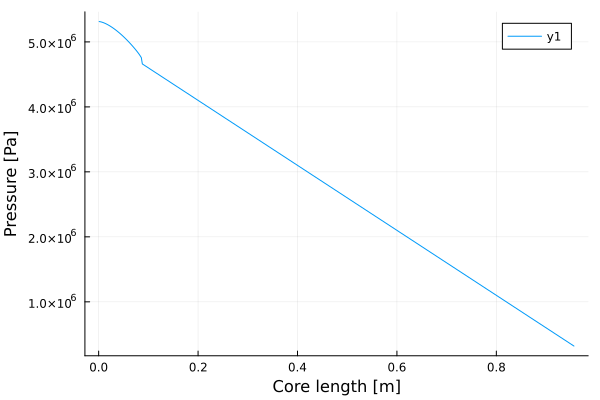

In [26]:
# plot(sw.value[2:end-1])
plot(meshvar.cellcenters.x, p.value[2:end-1], 
    xlabel="Core length [m]",
    ylabel="Pressure [Pa]",
    )

In [55]:
plot(meshvar.cellcenters.x, [krg.(sw.value[2:end-1]) kr.(sw.value[2:end-1])].+1e-10, 
    xlabel="Core length [m]",
    ylabel="Relative mobility",
    yaxis=:log,
    tickfontsize=11,
    label=["Foam" "Gas"],
    dpi=300)
savefig("relative_mobility.png")